# Simple example for uncorrelated distortions:

In [1]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import os, sys
sys.path.append("../")
from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule
from utils.test import t_to_pvalue_empirical, t_to_pvalue

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

plt.style.use('./mystyle.mplstyle')

mygold = (218/255, 165/255, 64/255, 0.1)  
mycolors = ['#570f6d', '#bb3754', '#f98e08']

## Simulations and utils

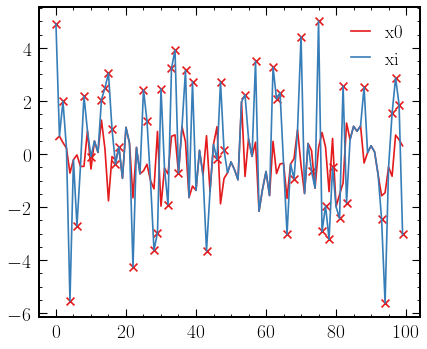

In [2]:
Nsims = 100_000
Nbins = 100
SIGMA = 1 
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.5, bkg=False, dtype=torch.float64)     
samples = simulator.sample(Nsims=Nsims)  

plt.plot(samples['x0'][0], label='x0')
plt.plot(samples['xi'][0], label='xi')
idx = torch.where(samples['ni'][0] != 0)
plt.scatter(idx, samples['xi'][0][idx], marker='x', s=50)
plt.legend();

## Training epsilon

In [ ]:
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [4]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
# dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/noemiam/.pyenv/versions/swyft-3.10.0/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorbo

Sanity Checking: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 11115.359


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 4621.155 >= min_delta = 0.0. New best score: 6494.204


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3059.055 >= min_delta = 0.0. New best score: 3435.149


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 871.404 >= min_delta = 0.0. New best score: 2563.746


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 67.569 >= min_delta = 0.0. New best score: 2496.177


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 14.283 >= min_delta = 0.0. New best score: 2481.894


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.306 >= min_delta = 0.0. New best score: 2478.588


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.846 >= min_delta = 0.0. New best score: 2474.742


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.630 >= min_delta = 0.0. New best score: 2471.112


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.5000e-03.
Epoch 00017: reducing learning rate of group 1 to 1.5000e-03.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 13.024 >= min_delta = 0.0. New best score: 2458.088


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00024: reducing learning rate of group 0 to 7.5000e-04.
Epoch 00024: reducing learning rate of group 1 to 7.5000e-04.


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 2458.088. Signaling Trainer to stop.


Reloading best model: /home/noemiam/sbi/mist/notebooks/lightning_logs/version_5/checkpoints/epoch=17-val_loss=2458.09.ckpt


tensor(4.4637, device='cuda:0', dtype=torch.float64)

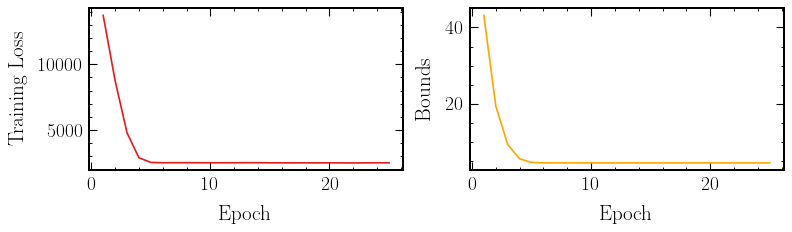

In [5]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout();

network_epsilon.bounds()

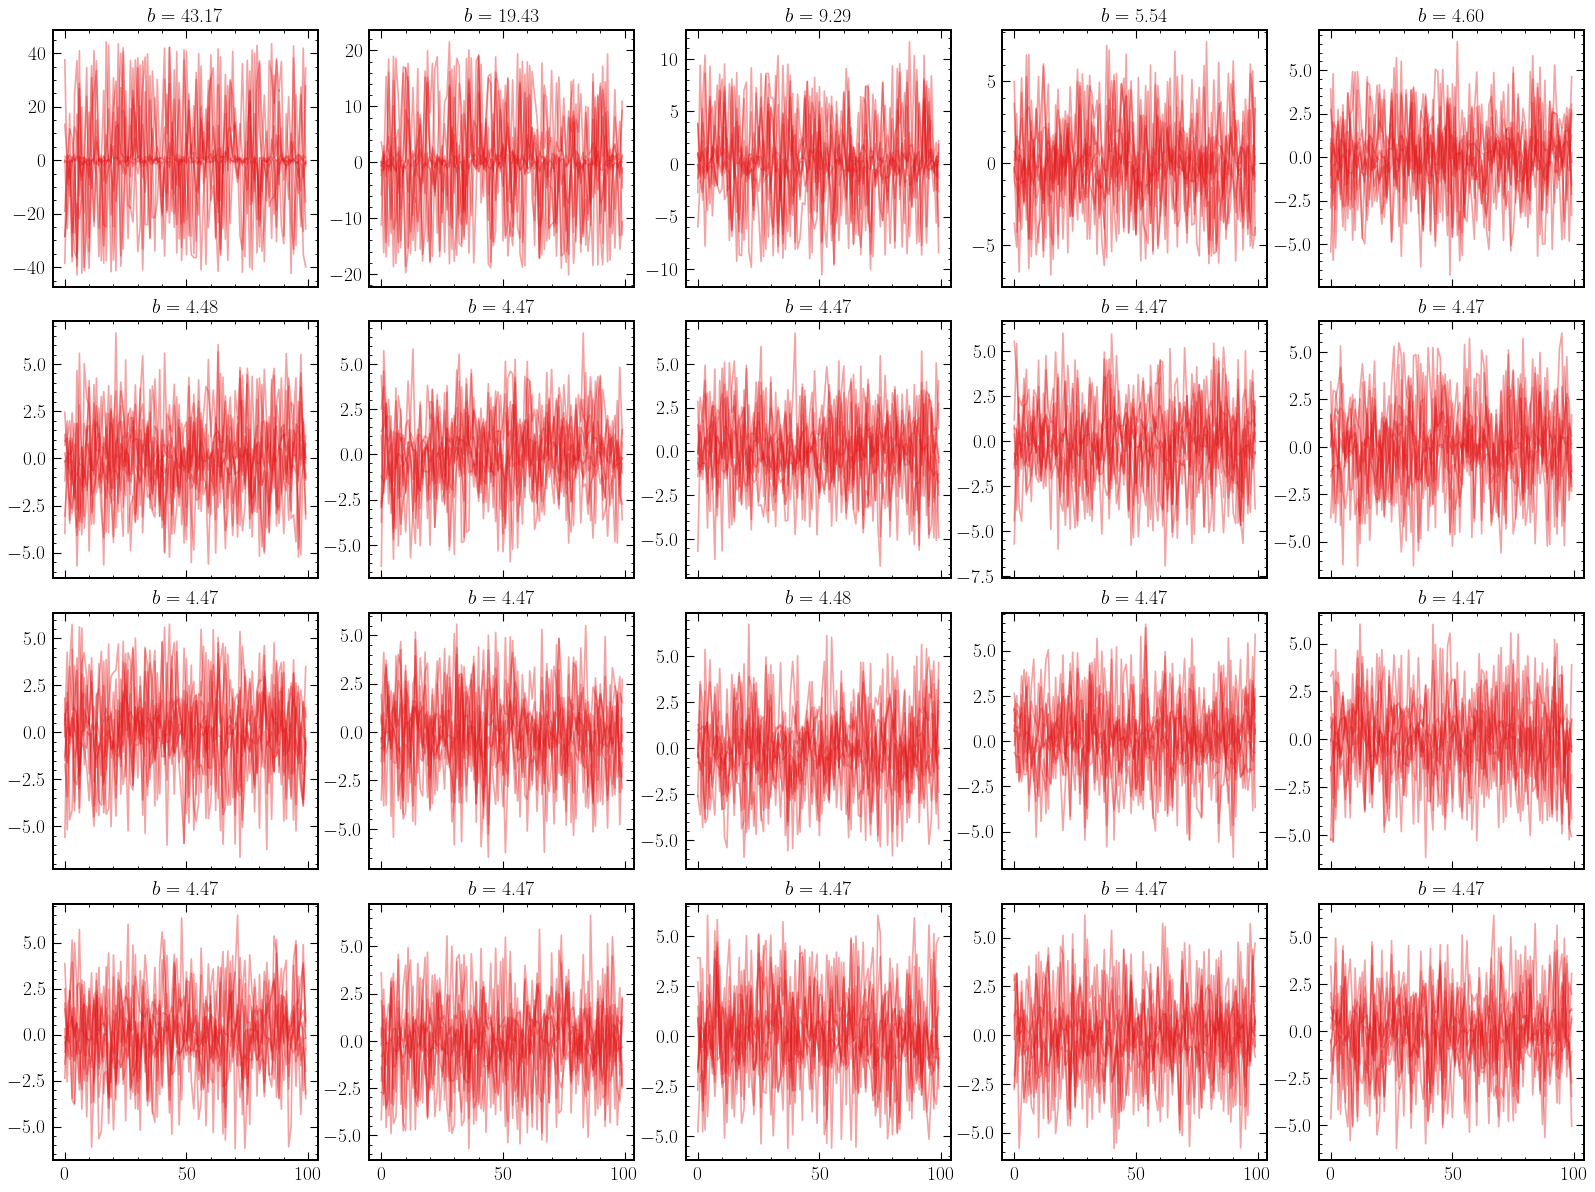

In [6]:
# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
plt.tight_layout();

---

### Evaluate

#### From here on test with bounds to which the NN converged: 

In [7]:
bounds = network_epsilon.bounds().detach().cpu().numpy()
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=False, bounds=bounds, fraction=0.1, dtype=torch.float64)     # Just one bin is distorted with fraction=None  

#### Check NN outputs

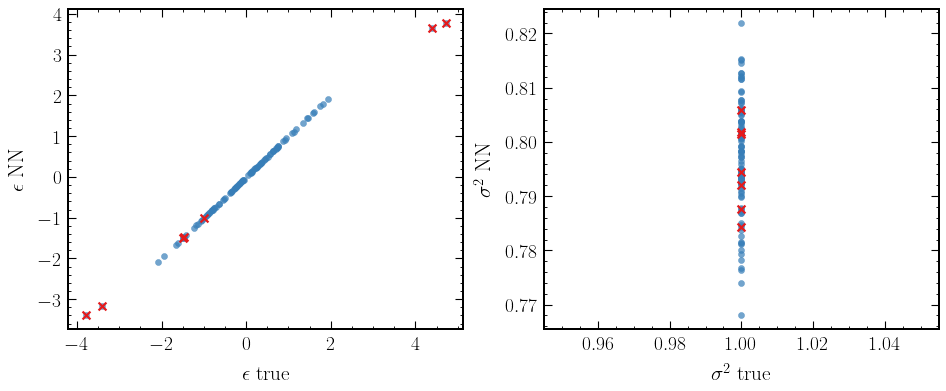

In [8]:
n = 50

obs = simulator.sample(1)  
delta_x = obs['xi']

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
epsilon_nn_obs = network_epsilon.epsilon(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
snr_nn_obs = network_epsilon.snr(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
epsilon_obs = get_epsilon(delta_x, ni).squeeze(0)
variance_obs = 1 / get_sigma_epsilon_inv2(ni)
snr_obs = get_snr(delta_x, ni).squeeze(0)


# For each simultion of the n ones, compute analytical quantities
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].scatter(x=epsilon_obs, y=epsilon_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[1].scatter(x=variance_obs, y=variance_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
    
idx = torch.where(obs['ni']==1)[1]
axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)

axs[0].set_xlabel(r'$\epsilon$ true')
axs[0].set_ylabel(r'$\epsilon$ NN')
axs[1].set_xlabel(r'$\sigma^2$ true')
axs[1].set_ylabel(r'$\sigma^2$ NN')
plt.tight_layout();

---

#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [9]:
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].cuda())**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)
ts_bin_H0_epsilon.shape

100%|██████████| 488/488 [03:48<00:00,  2.14it/s]


(1998848, 100)

Histogram of $t_i | H_0$ in individual bins

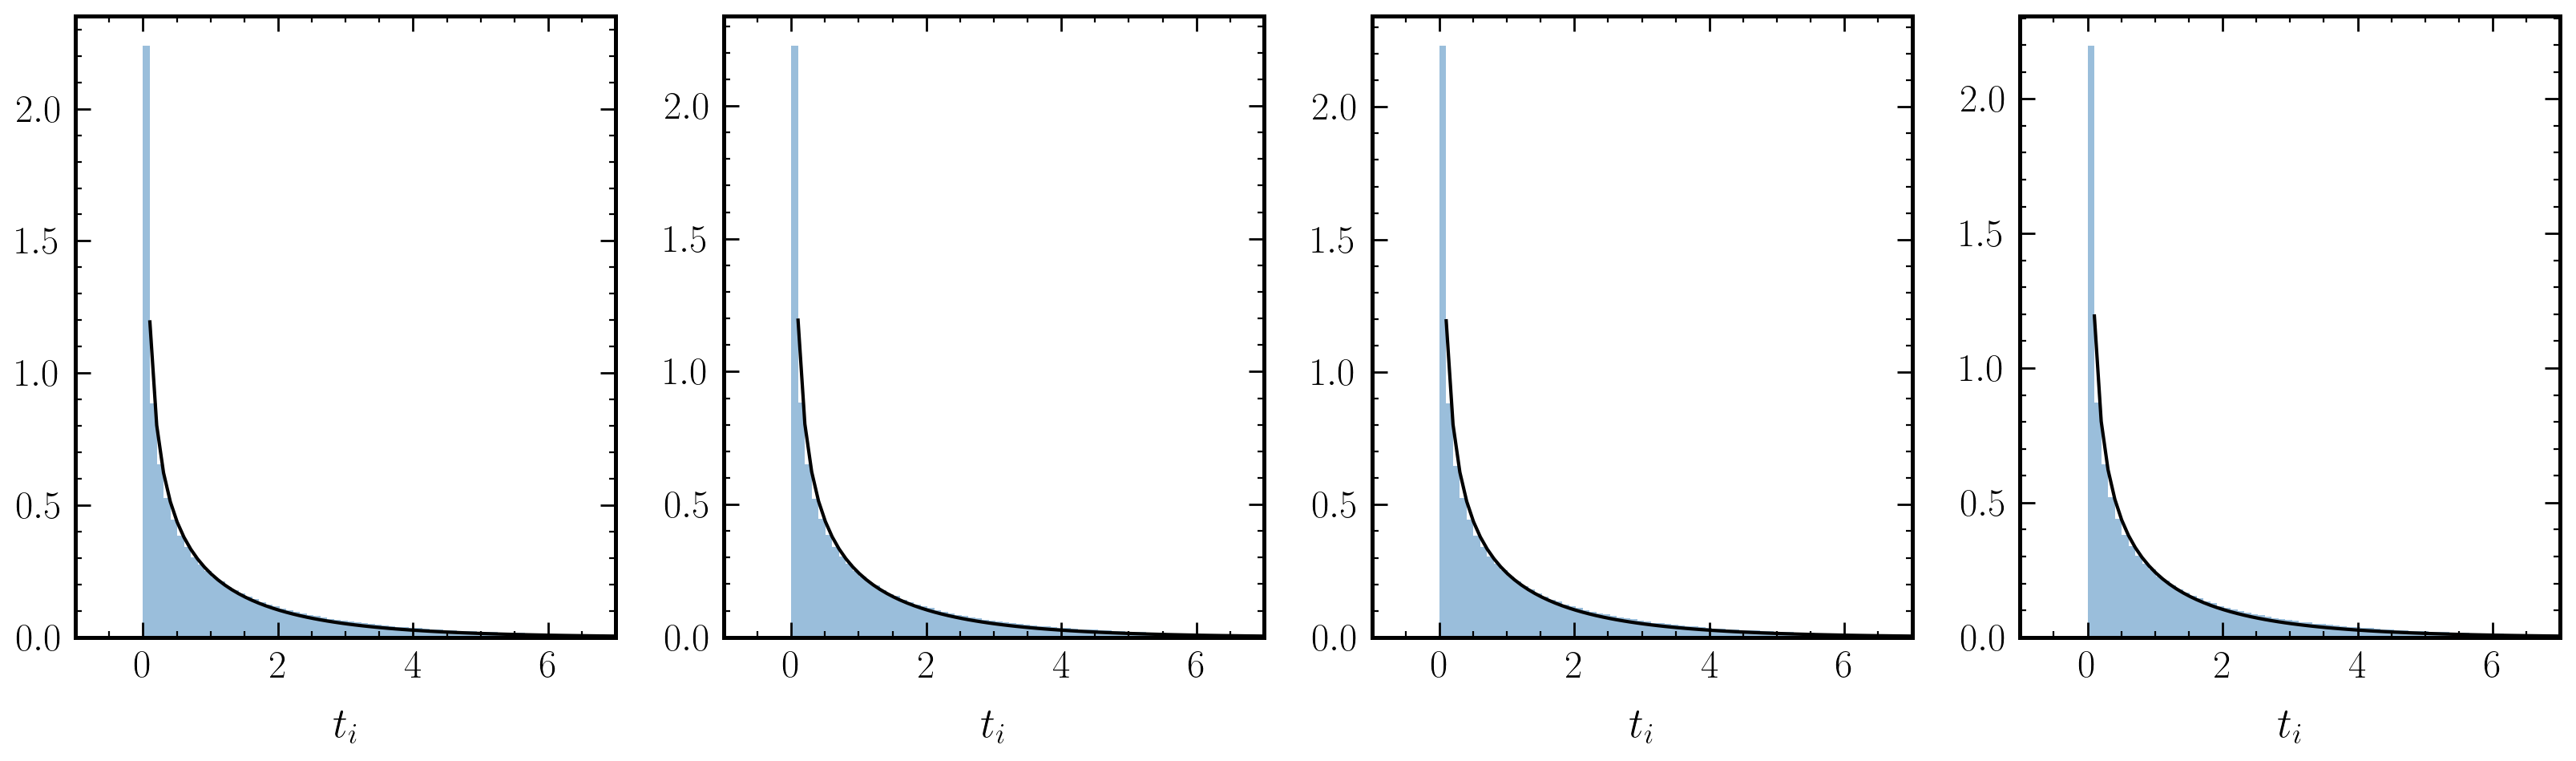

In [10]:
# Compare with chi2 with df = 1
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_epsilon[:, bin]

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')

---

#### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection
- Residual analysis with $\epsilon_i$ map

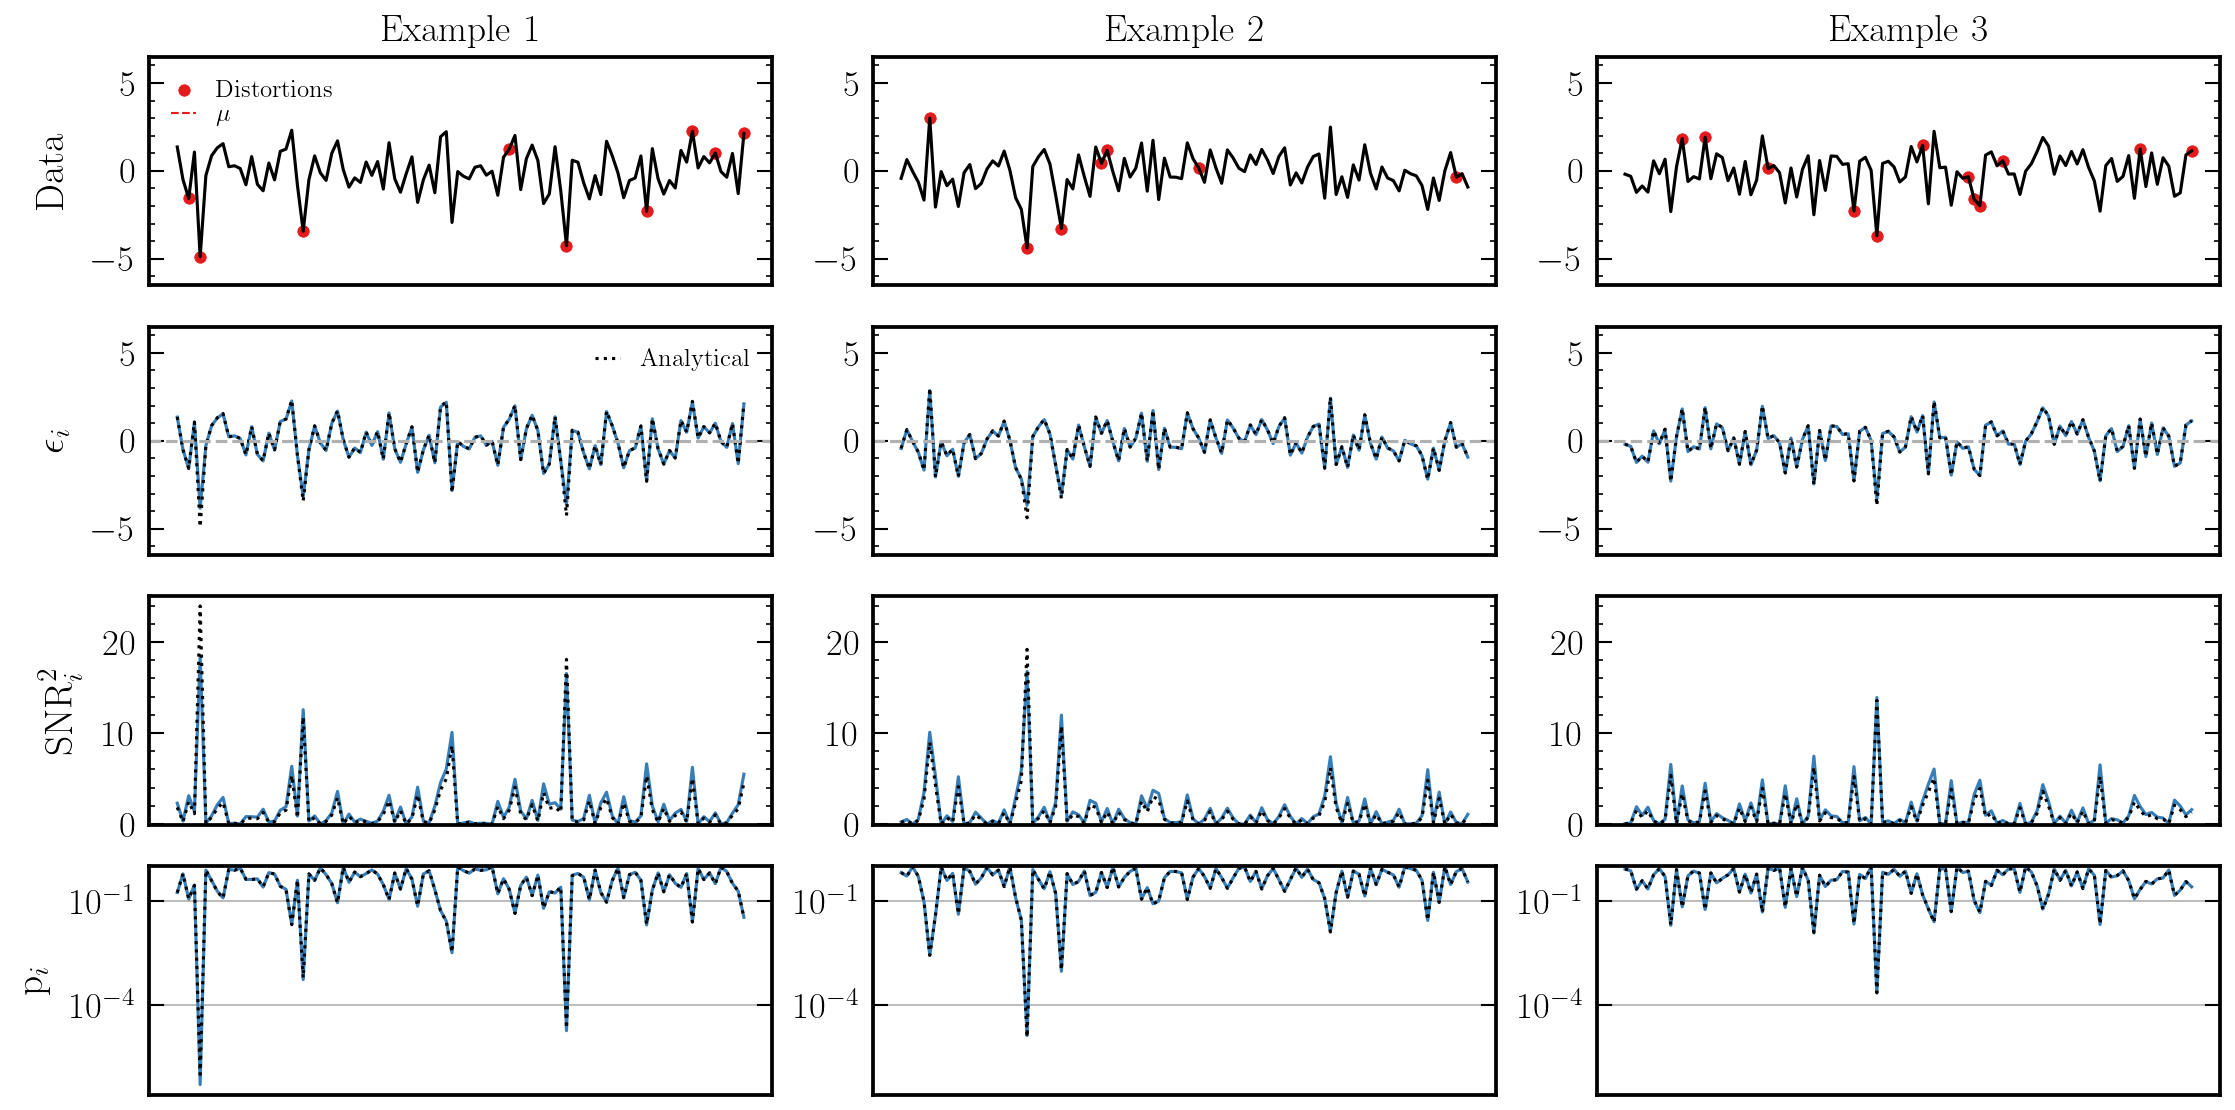

In [11]:
fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    
    # Compute analytical epsilon and SNR^2 test statistic
    ni_temp = torch.eye(Nbins, dtype=torch.float64)
    delta_x = obs['xi']
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2

    # Compute p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 dof per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid, epsilon_nn, c='C1')
    axs[1, i].plot(grid, epsilon_analytical, c='k', ls='dotted', label='Analytical')
    axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn, c='C1')
    axs[2, i].plot(grid, snr2_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(-0.1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn, c='C1')
    axs[3, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[3, i].set_ylim(1/N_mc/2, 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$\epsilon_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3, 0].set_ylabel("$\mathrm{p}_i$")
plt.tight_layout();

---

#### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p}_{\rm sum}$ for model validation
- Residual variance analysis with $\epsilon_i$ histogram

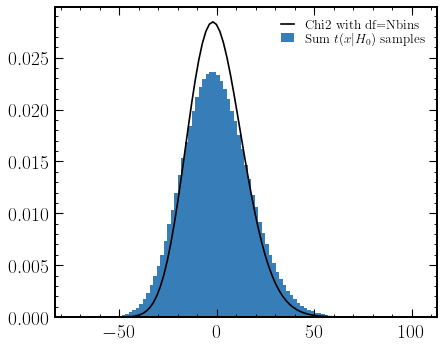

In [12]:
DOF = Nbins

# From MCMC samples
ts_sum_H0_epsilon = ts_bin_H0_epsilon.sum(axis=1)
ts_sum_H0_epsilon_mean = ts_sum_H0_epsilon.mean()
ts_sum_H0_epsilon = ts_sum_H0_epsilon - ts_sum_H0_epsilon_mean

# Plot
plt.figure()
bins = np.linspace(ts_sum_H0_epsilon.min(), ts_sum_H0_epsilon.max(), 100)
plt.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')
plt.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='C1', label='Sum $t(x|H_0)$ samples')
plt.legend(loc='best', fontsize=12, labelspacing=0.1);

---

#### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test.


In [13]:
ts_bin_H0_epsilon.shape, ts_sum_H0_epsilon.shape

((1998848, 100), (1998848,))

Compute p-values for the individual tests (Nbins)

In [14]:
N_mc, num_bins = ts_bin_H0_epsilon.shape
ts_bin_flat = ts_bin_H0_epsilon.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    
    
pv_bin_H0.shape

(1998848, 100)

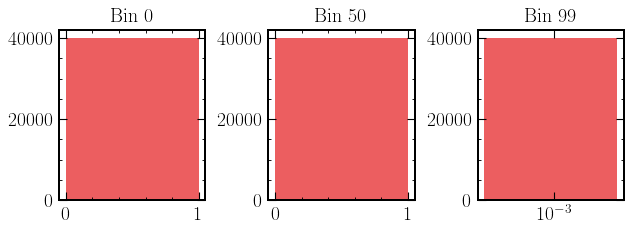

In [15]:
# p-values are uniformly distribute

selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

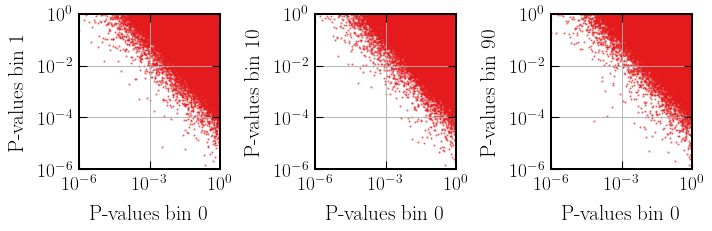

In [16]:
# p-values between different tests are correlated

bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


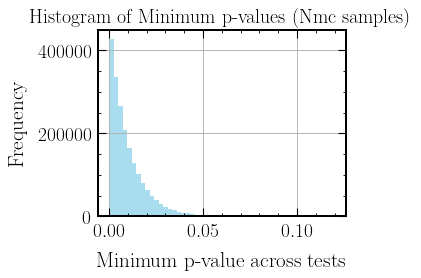

In [17]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_epsilon = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests

In [18]:
means = ts_sum_H0_epsilon.mean(axis=0)  # Shape: [1]
ts_centered = ts_sum_H0_epsilon - means  # Shape: [N_mc]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values
pv_sum_H0.shape

(1998848,)

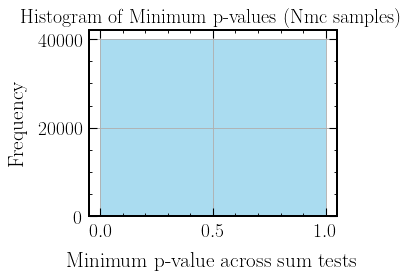

In [19]:
min_pv_sum_H0_epsilon = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


(1998848, 101)


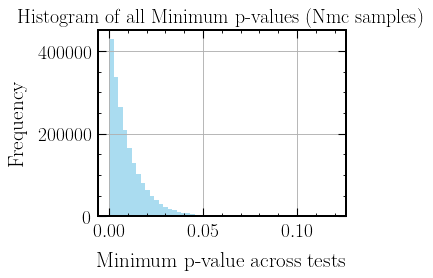

In [20]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0.reshape(Nmc, -1)], axis=1)  # Shape: [Nmc, num_bins + 1]
print(pv_all_H0.shape)

min_pv_all_H0_epsilon = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


---

### Summary plot

In [21]:
def analyse_obs_epsilon(obs):
    
    target = obs['xi']
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   

    
    # Compute analytical epsilon and SNR^2 test statistic
    ni_temp = torch.eye(Nbins, dtype=torch.float64)
    delta_x = obs['xi']
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() 
    p_sum_analytical = t_to_pvalue(ts_sum_analytical, DOF)

    # Compute localized p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_epsilon <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_epsilon <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    c = ["C0", "C1", "C2"]
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column c = mycolor[1]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c = mycolors[1], label=r"$\textsc{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, epsilon_nn, c = mycolors[1], label=r"$\textsc{SBI}$")
    ax3.plot(grid, epsilon_analytical, c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])
    ax3.set_title("Residual analysis")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column
    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor = mycolors[1], edgecolor = mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    ax6.hist(epsilon_nn / np.sqrt(variance_nn), bins=bins, density=True, color = mycolors[1], alpha=0.5)
    ax6.hist(epsilon_analytical, bins=bins, density=True, histtype='step', color='k', linestyle = 'dotted')
    ax6.set_xlim(-5*SIGMA, 5*SIGMA)
    ax6.set_xlabel("$\epsilon_\mathrm{obs}/\sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    plt.tight_layout();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.00043925300973360657, 4.8169139129439344e-06)

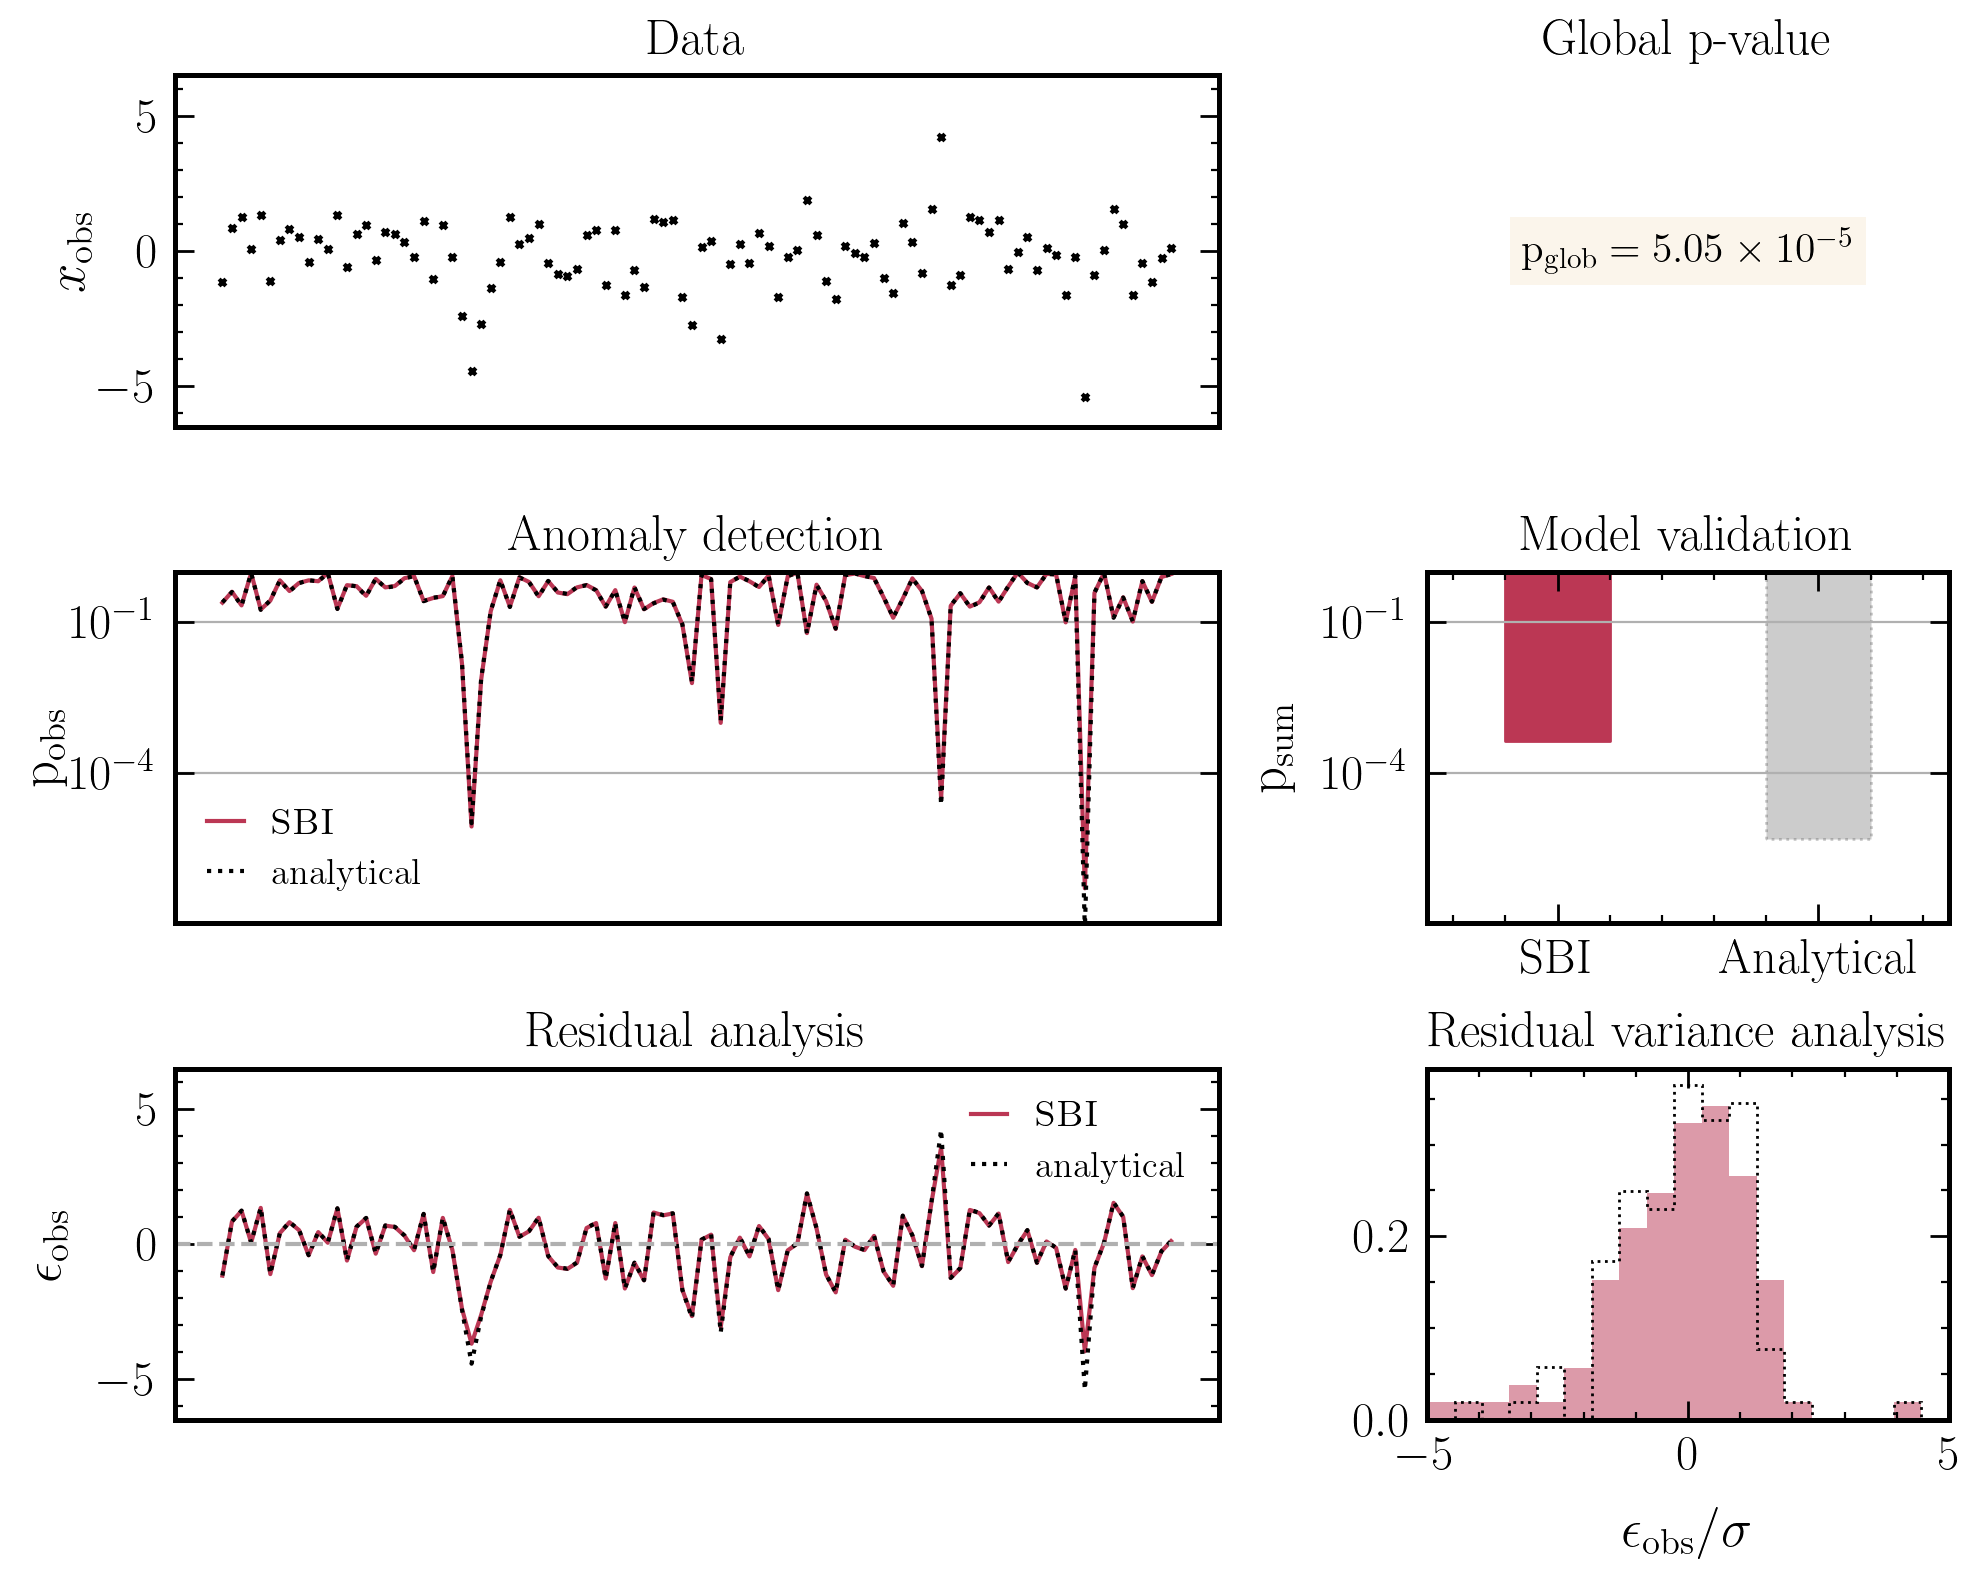

In [22]:
# OBS
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=False, bounds=bounds, fraction=0.1, dtype=torch.float64)     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

## Training BCE

In [23]:
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=bounds, fraction=0.5, bkg=False, dtype=torch.float64)     

In [24]:
from models.resnet_1d import ResidualNet
from models.online_norm import OnlineStandardizingLayer

class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

In [25]:
# Train
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']    
    for k, v in sample.items():
        if v.ndim > 1:
            sample[k] = v.squeeze(0)
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
# dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_BCE = Network_BCE()
model = BCELossModule(network_BCE, learning_rate=8e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=100, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_BCE.cuda().eval();

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/noemiam/.pyenv/versions/swyft-3.10.0/lib/pytho ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float

Sanity Checking: 0it [00:00, ?it/s]

/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/noemiam/.pyenv/versions/swyft-3.10.0/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.480


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.479


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.478


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 4.0000e-03.


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 7 records. Best score: 0.478. Signaling Trainer to stop.


Reloading best model: /home/noemiam/sbi/mist/notebooks/lightning_logs/version_6/checkpoints/epoch=4-val_loss=0.48.ckpt


### Evaluate

Define test statistic

$TS(x) = - 2 \log\frac{p(x|H_0)}{p(x|H_1)} = 2 f_\phi(x)$

In [26]:
def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_cuda(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

#### Monte-Carlo H0

$$
    t_i(\mathbf x) \propto \text{SNR}_i^2(\bm x)  
$$

In [27]:
N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)

ts_bin_H0_BCE.shape

100%|██████████| 488/488 [03:49<00:00,  2.13it/s]


(1998848, 100)

Histogram of $t_i | H_0$ in individual bins

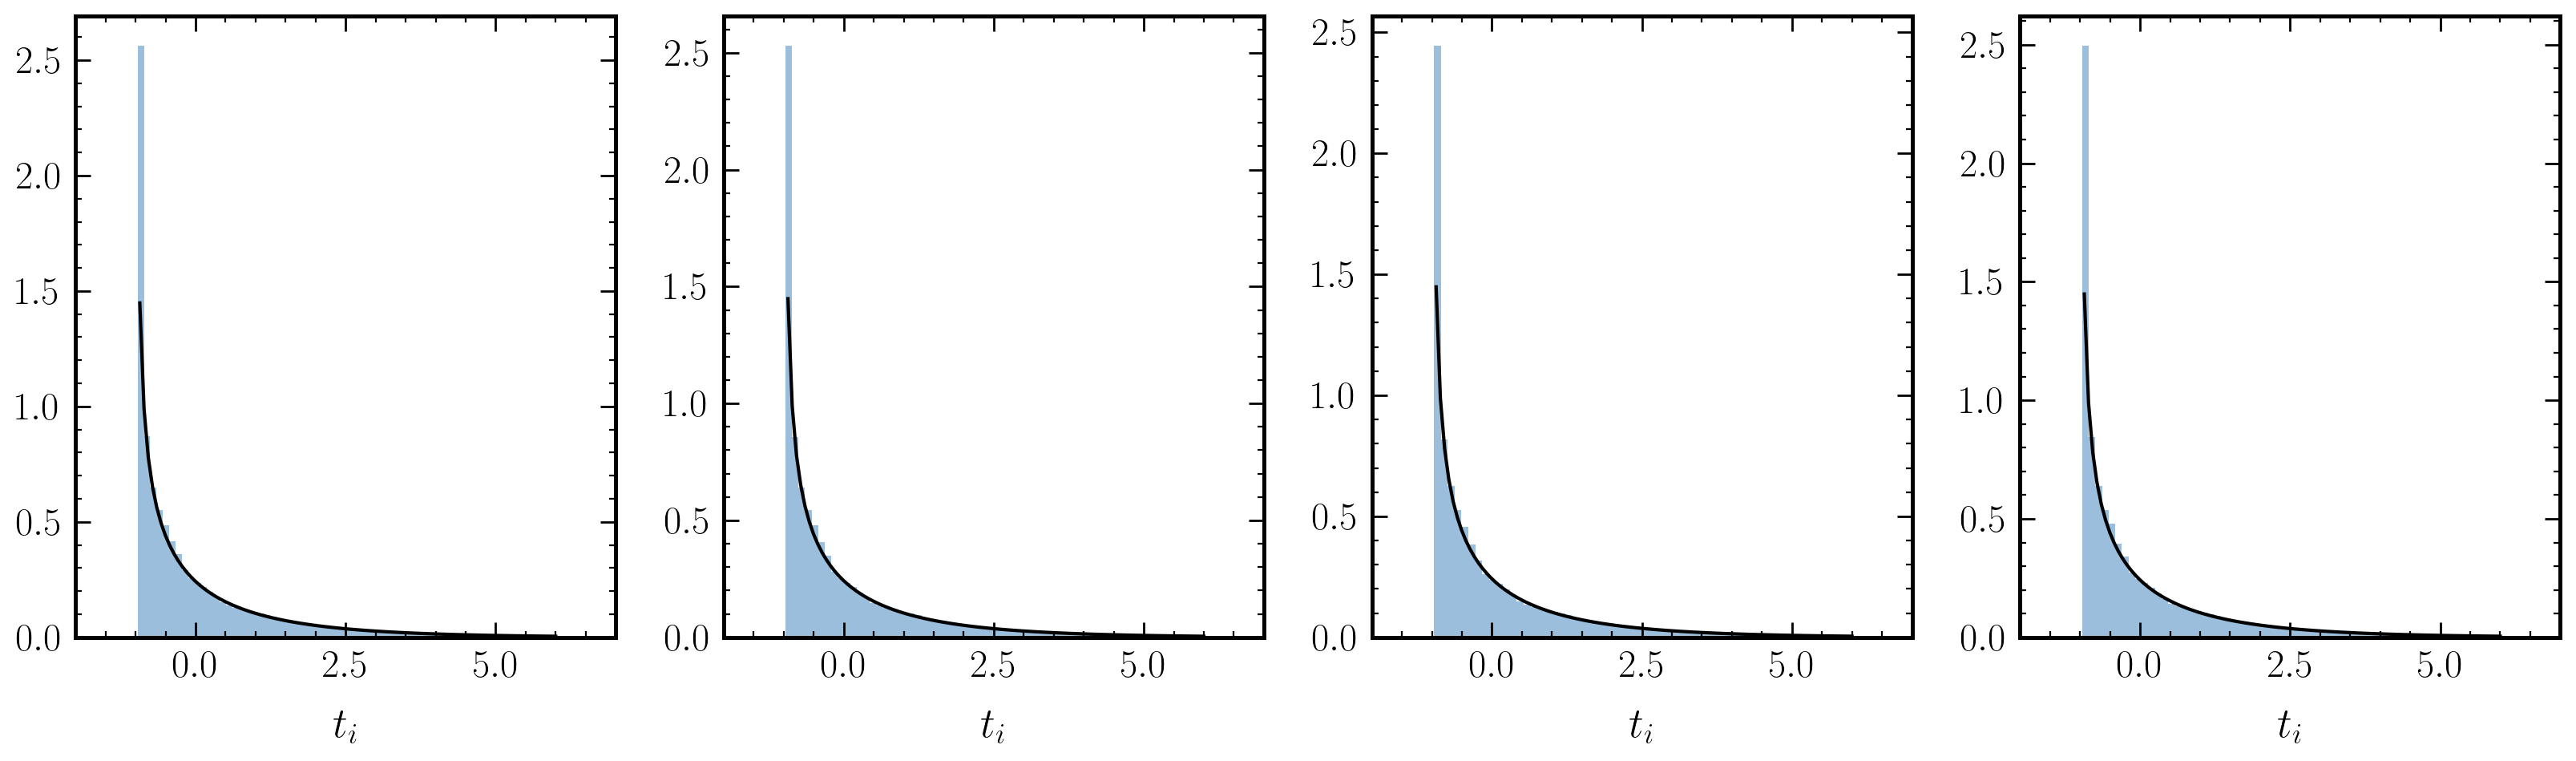

In [28]:
# Compare with chi2 with df = 1
grid = np.linspace(-1, 6, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_BCE[:, bin]
    m = ts_bin_i.mean()

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i-m, bins=200, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-2, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')

---

#### Individual deviations test

- Localized $t_i$
- Localized $\mathrm{p}_i$ for anomaly detection

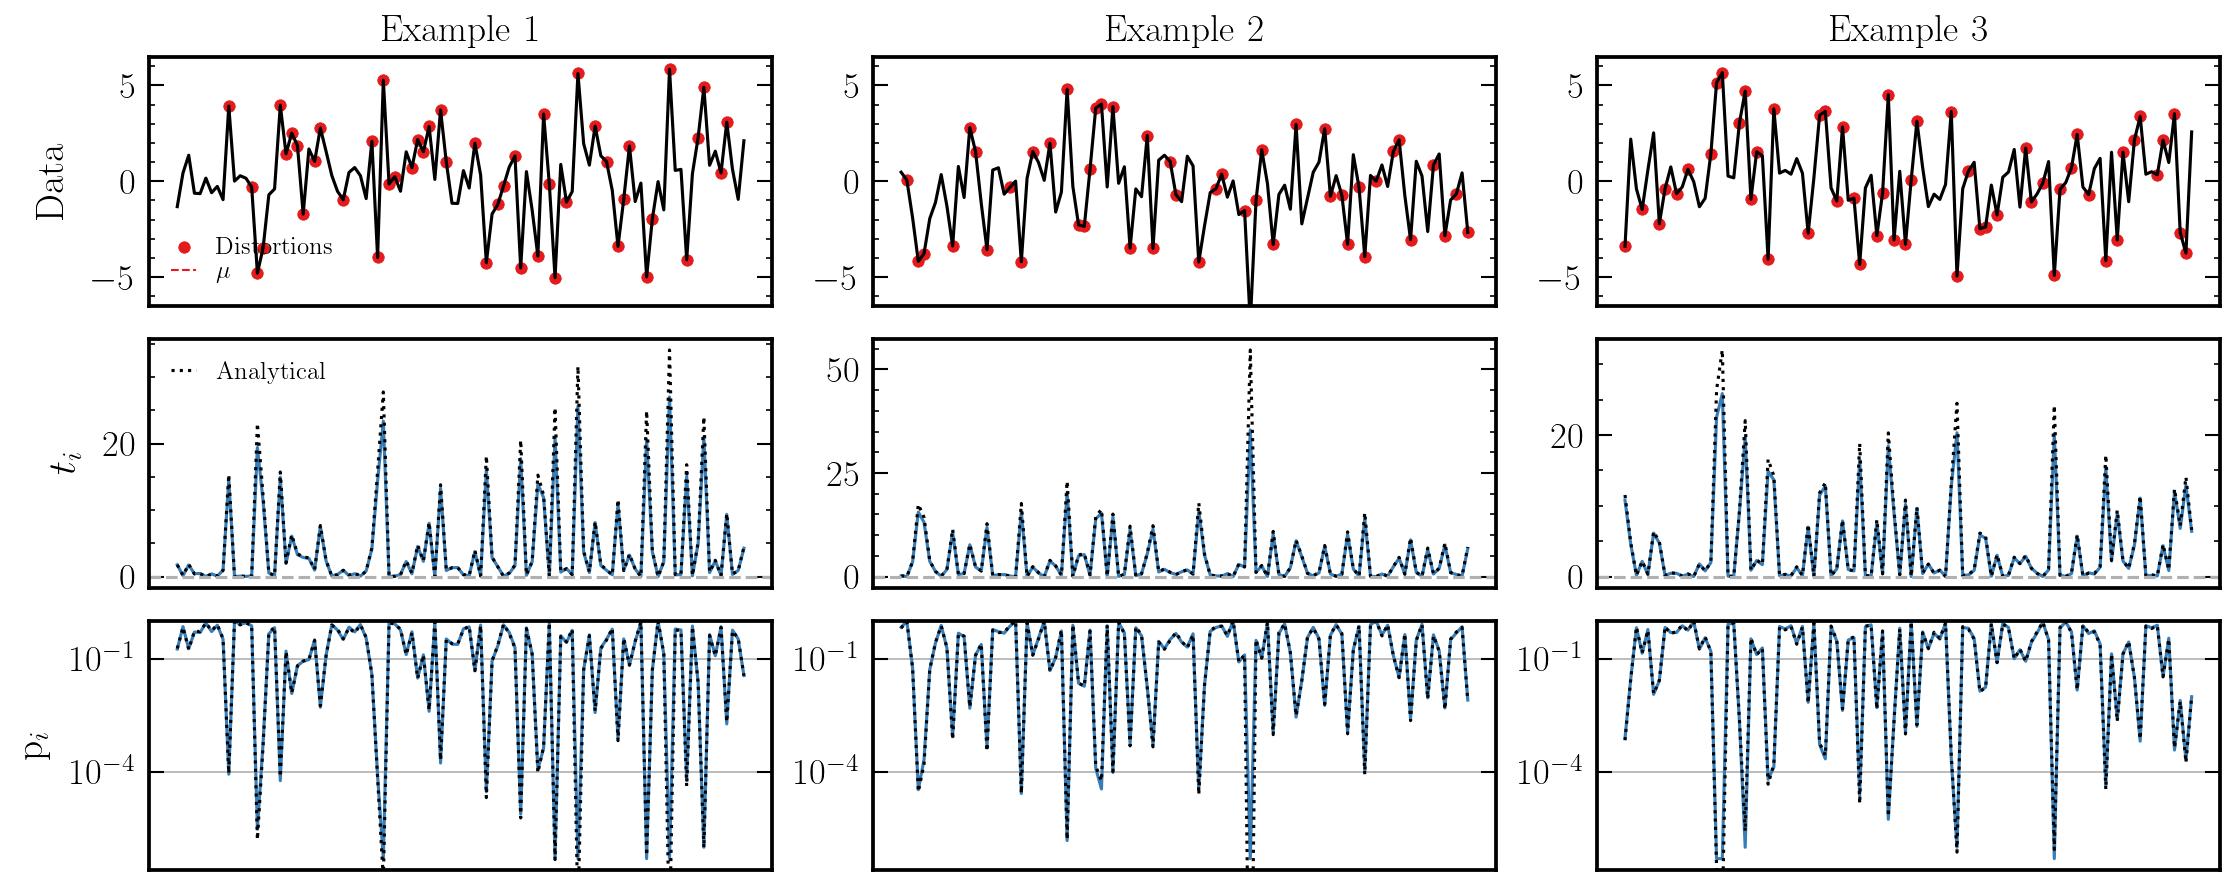

In [29]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi'])**2)/SIGMA**2)[0]-1

    # Compute p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx] + 1, 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid,  ts_bin_obs-ts_bin_obs.min(), c='C1')
    axs[1, i].plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted', label='Analytical')
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])

    axs[2, i].semilogy(grid, p_nn, c='C1')
    axs[2, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(1/N_mc/2, 1)
    axs[2, i].grid(True, axis='y')
    axs[2, i].set_xticks([])
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$t_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel("$\mathrm{p}_i$")
plt.tight_layout();


---

#### Total deviations test

- Aggregated $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $
- Aggregated $\mathrm{p}_{\rm sum}$ for model validation

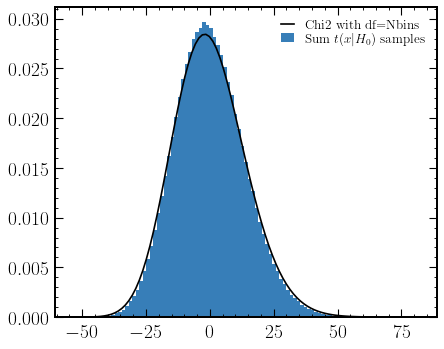

In [30]:
DOF = Nbins #- 3 # 3 parameters

# From MCMC samples
ts_sum_H0_BCE = ts_bin_H0_BCE.sum(axis=1)
ts_sum_H0_BCE_mean = ts_sum_H0_BCE.mean()
ts_sum_H0_BCE = ts_sum_H0_BCE - ts_sum_H0_BCE_mean

# Plot
plt.figure()
bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
plt.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')
plt.hist(ts_sum_H0_BCE, bins=bins, density=True, color='C1', label='Sum $t(x|H_0)$ samples')
plt.legend(loc='best', fontsize=12, labelspacing=0.1);

---

#### Global deviations test

Trial correct for the fact that we looked Nbins times + aggregated tests. What’s the overall significance given I’ve looked so many times? Each of the trials is one test.


In [31]:
ts_bin_H0_BCE.shape, ts_sum_H0_BCE.shape

((1998848, 100), (1998848,))

Compute p-values for the individual tests (Nbins)

In [32]:
N_mc, num_bins = ts_bin_H0_BCE.shape
ts_bin_flat = ts_bin_H0_BCE.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    
    
pv_bin_H0.shape

(1998848, 100)

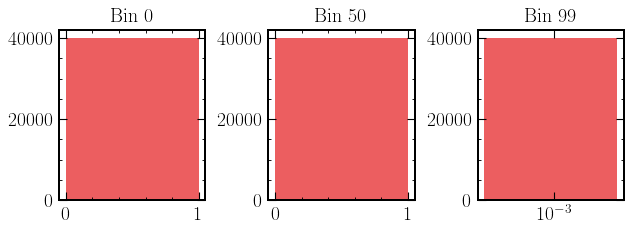

In [33]:
# p-values are uniformly distribute

selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')

plt.tight_layout()
plt.show()

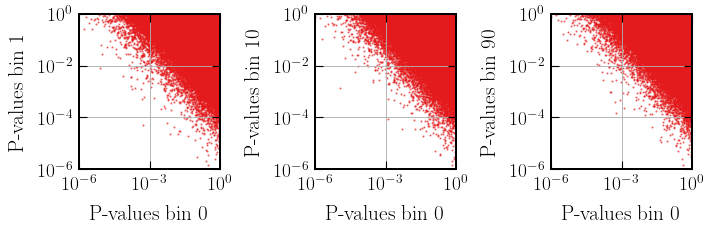

In [34]:
# p-values between different tests are correlated

bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


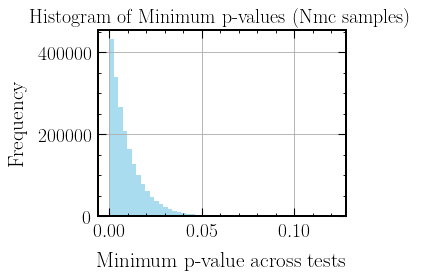

In [35]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_BCE = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Compute p-values for the total tests

In [36]:
means = ts_sum_H0_BCE.mean(axis=0)  # Shape: [1]
ts_centered = ts_sum_H0_BCE - means  # Shape: [N_mc]
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_sum_H0 = p_values
pv_sum_H0.shape

(1998848,)

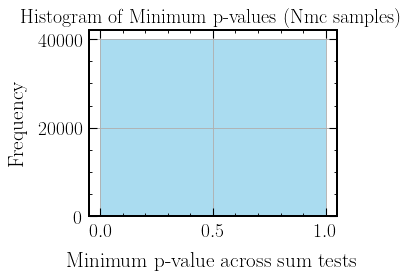

In [37]:
min_pv_sum_H0_BCE = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_sum_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across sum tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


Consider all tests

(1998848, 101)


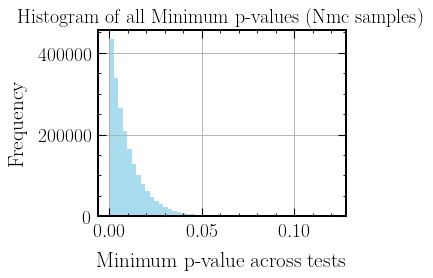

In [38]:
# MINIMUM

Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([pv_bin_H0.reshape(Nmc, -1), pv_sum_H0.reshape(Nmc, -1)], axis=1)  # Shape: [Nmc, num_bins + 1]
print(pv_all_H0.shape)

min_pv_all_H0_BCE = np.min(pv_all_H0, axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of all Minimum p-values (Nmc samples)')
plt.grid(True)
plt.show()


In [39]:
ts_bin_H0_BCE.shape, ts_sum_H0_BCE.shape

((1998848, 100), (1998848,))

---

#### Summary plot

In [ ]:
def analyse_obs_BCE(obs):
        
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi'])**2)/SIGMA**2)[0]-1
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    ts_sum_obs_analytical = (((obs['xi'])**2)/SIGMA**2).sum()-DOF
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx]+1, 1))
    p_nn = np.array(_p_nn)
    p_analytical = np.array(_p_analytical)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)   
    p_sum_analytical = t_to_pvalue(ts_sum_obs_analytical+DOF, DOF)

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_BCE <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_BCE <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c=mycolors[1], label=r"$\textsc{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\textsc{SBI}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    # ax3.set_xlabel("$i$", labelpad=1.5)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    plt.tight_layout();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


True

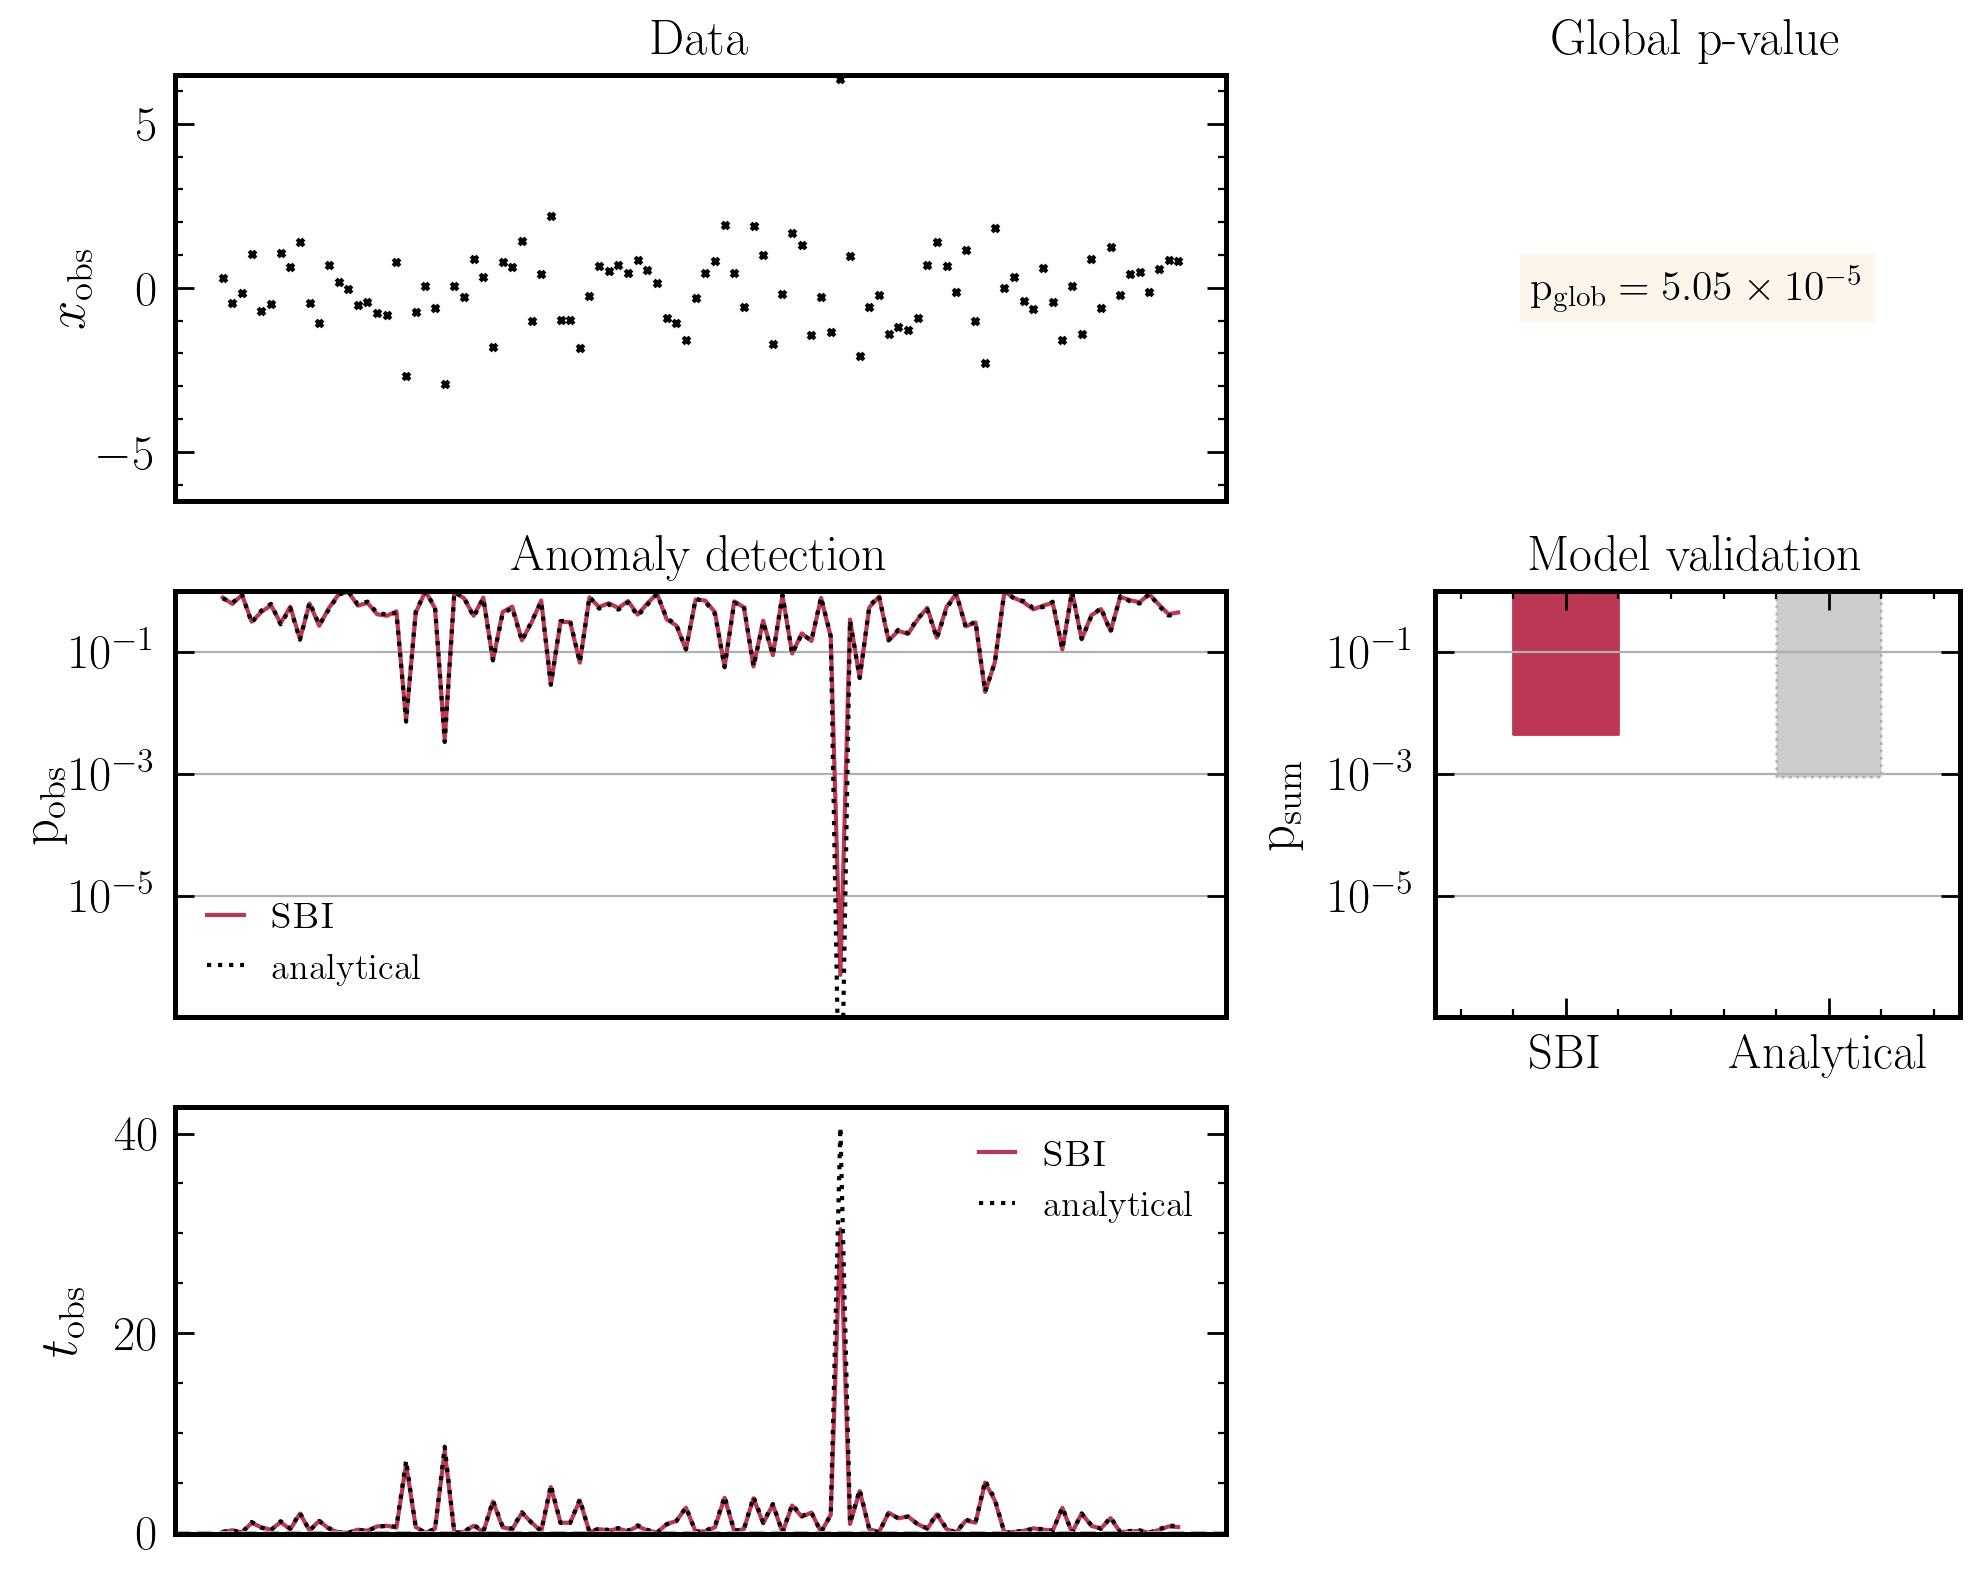

In [42]:
# OBS
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=False, bounds=bounds, fraction=0.05, dtype=torch.float64)     # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 

ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_BCE(obs)
plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn > p_sum_analytical

## Combine plot

In [ ]:
def plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    ):
    
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(bbox_to_anchor=(0.05, 1), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn_BCE, c=mycolors[1], label=r"$\textsc{BCE}$")
    ax2.semilogy(grid, p_nn_epsilon, c=mycolors[2], label=r"$\textsc{SNR}$")
    ax2.semilogy(grid, p_analytical_BCE, c='k', ls='dotted', label=r"Analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\textsc{BCE}$")
    ax3.plot(grid, snr2_nn-snr2_nn.min(), c=mycolors[2], label=r"$\textsc{SNR}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"Analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='upper left', fontsize=13, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("Localized $t_i$")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["BCE", "SNR", "Analytical"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_nn_epsilon, facecolor=mycolors[2], edgecolor=mycolors[2])
    ax4.fill_between([1.8, 2.2], 1, p_sum_analytical_epsilon, facecolor='k', alpha=0.5)
    ax4.plot([1.8, 1.8, 2.2, 2.2], [1, p_sum_analytical_epsilon, p_sum_analytical_epsilon, 1], 'k', linestyle='dotted')  
    ax4.set_title("Model validation")
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    
    # SUM
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], alpha=0.5, label='BCE')
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], histtype='step')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], alpha=0.5, label='SNR')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], histtype='step')
    ax6.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', linestyle = 'dotted', label='Analytical')
    ax6.set_xlabel("$t_\mathrm{sum}$ $\mid H_0$")
    ax6.set_title("$\chi^2$")
    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    mantissa, exp = ('%.2e' % p_glob_all_epsilon).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


True True True


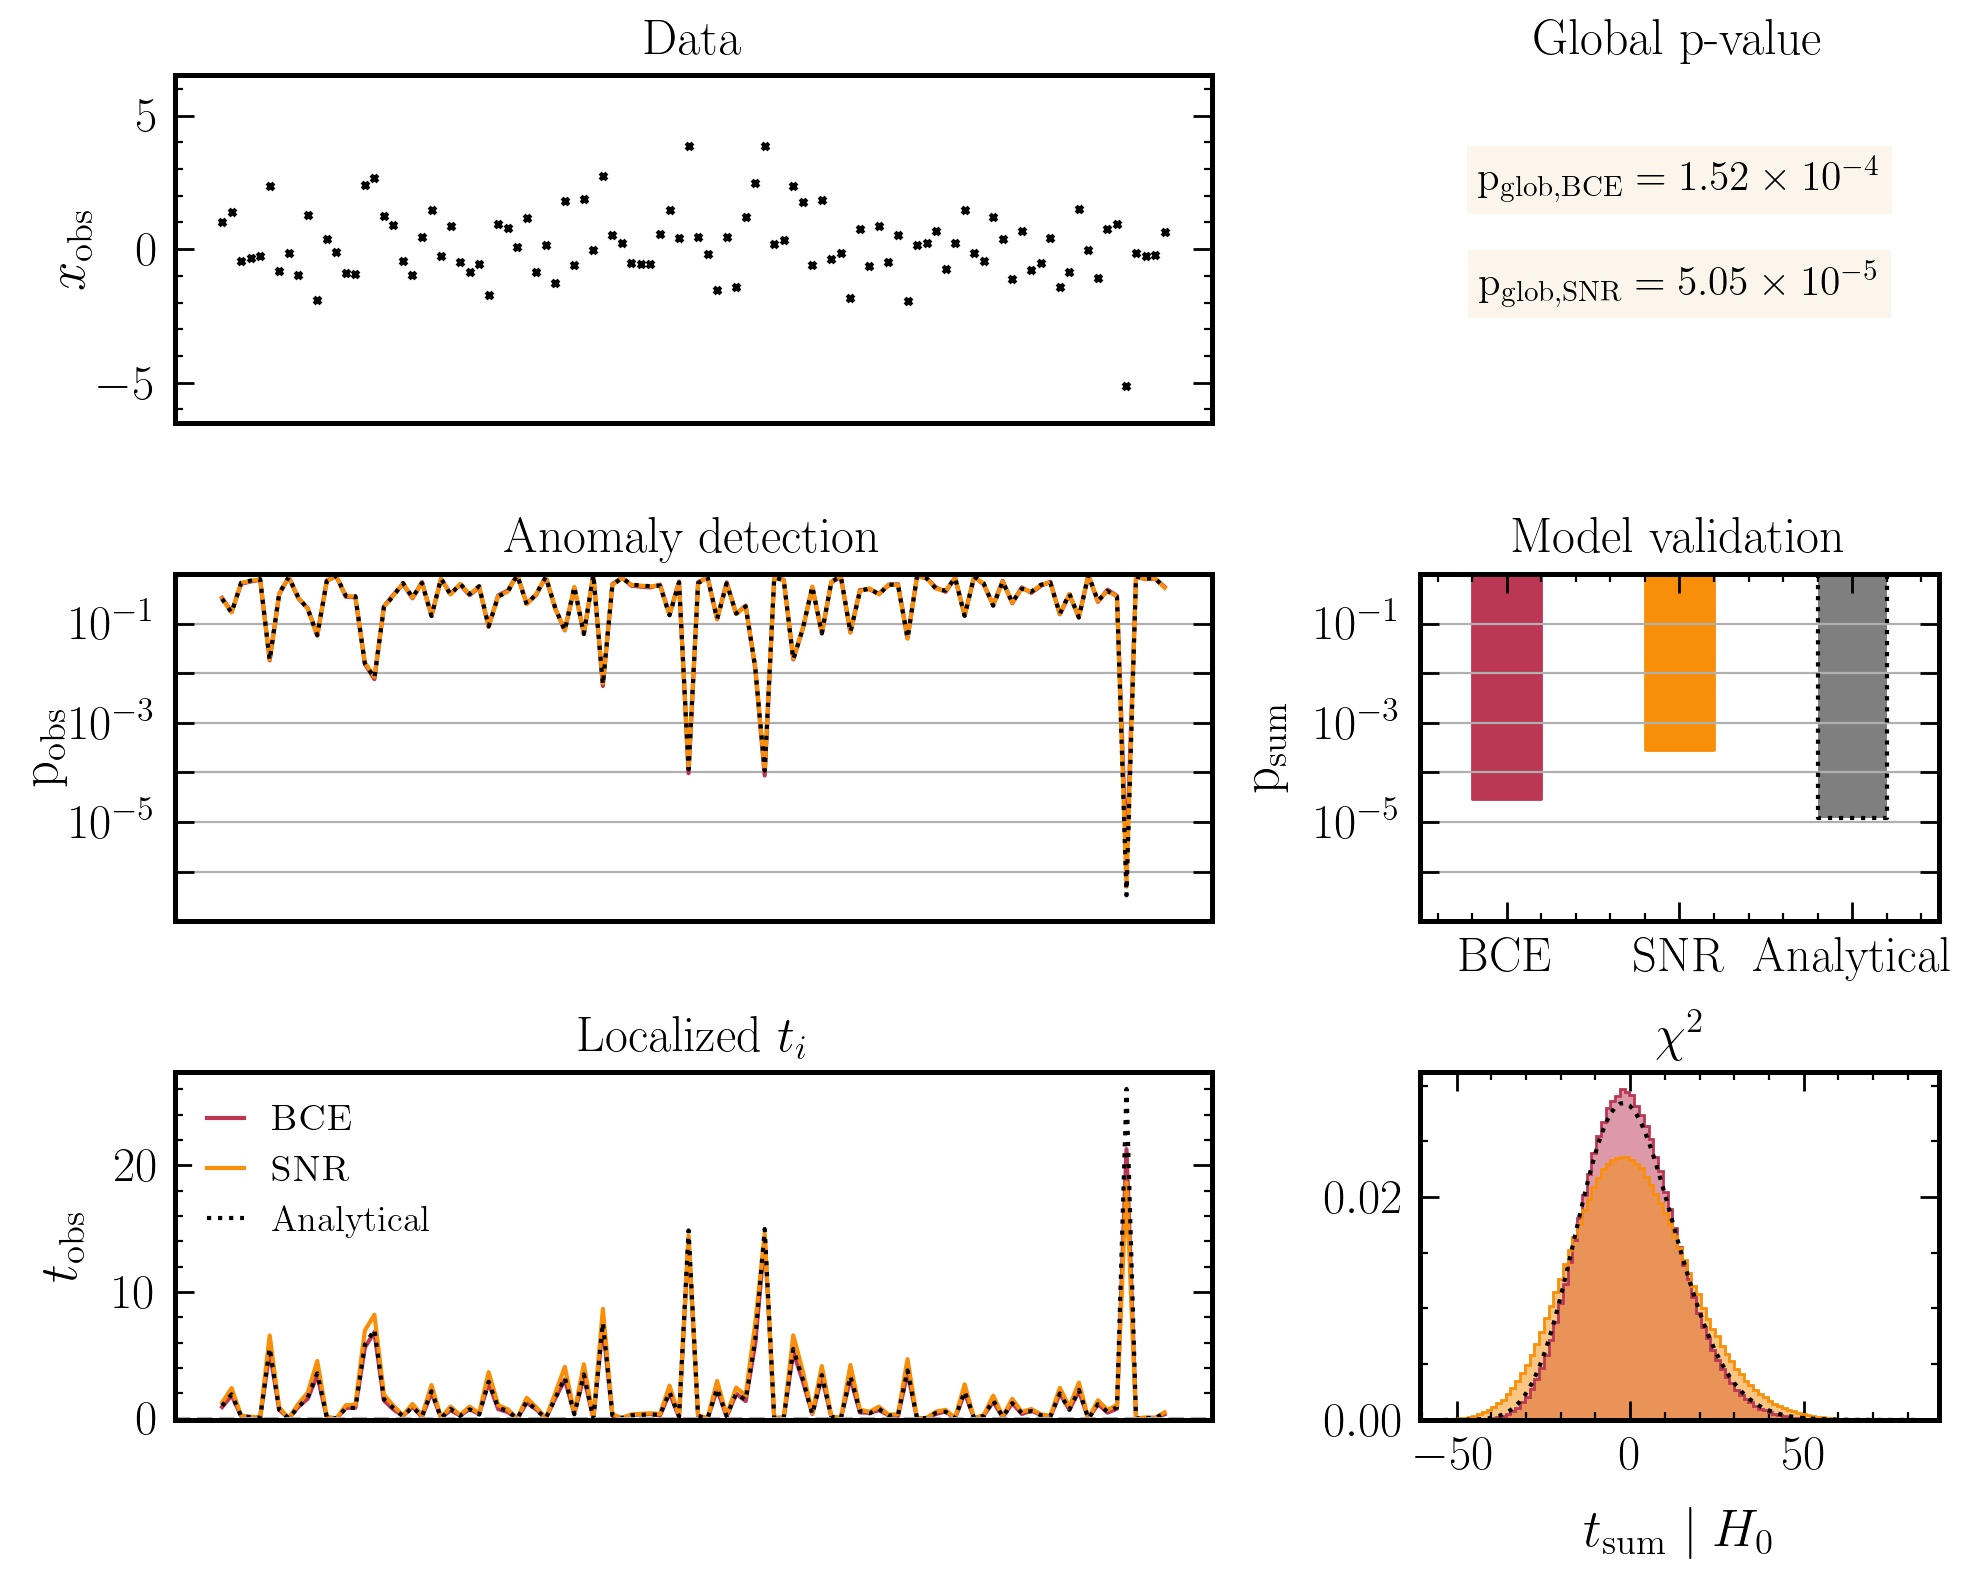

In [46]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=False, bounds=bounds, fraction=0.05, dtype=torch.float64) 
obs = simulator1.sample(1) 
    
ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    )

print(p_sum_analytical_BCE==p_sum_analytical_epsilon, p_sum_nn_BCE>p_sum_analytical_BCE,  p_sum_nn_epsilon>p_sum_analytical_epsilon)